In [1]:
import numpy as np
import pandas as pd

from preprocessing.data_transformation import DataTransformer
from preprocessing.feature_selection import FeatureSelector
from anomaly.detection import AnomalyDetector
from catboost import CatBoostRegressor

from models.arima import Arimer
from models.boost import CatBooster

MODELS_DICT = {'arima': Arimer, 'boost': CatBooster}

In [2]:
# ГлОбАлЬнЫе ПеРеМеНнЫе
MODEL_TYPE = 'boost'  # ['arima', 'boost'] - which model to use (also will be used in feature selection if available)
TRAIN_SIZE = 0.95  # [0 - 1] - will split TimeSeries into train and test like NOW is TRAIN_SIZE time moment
                   # Dont forget that it will cut train_ts and test_ts [LAG_SZ - 1 : -1] because of unfilled lags
USE_ANOMALY_DETECTION = True  # [True, False] - to include anomaly detection in feature building
USE_FEATURE_SELECTION = True  # [True, False] - to use feature selection before model learning
USE_CHANGEPOINT_DETECTION = True
FEATURE_SELECTION_TYPE = '3'  # ['1', '2', '3', '4']  - which exact feature selection algo to use
FEATURE_SELECTOR_FILEPATH = None  # where to save or load trained feature_selector
LAG_SZ = 10  # how many lags will be used in catboost learning (It learns on lags, not on time series)

In [3]:
# читаем данные
ts = pd.read_excel('./data.xlsx', index_col=0, parse_dates=True)
ts = ts.resample('D').sum()

In [4]:
# разбиваем ряд на тренировочную и тестовую вывборки
train_ts, test_ts = DataTransformer.split_ts(ts, TRAIN_SIZE)

In [6]:
# создаем инстанс трансформера для добавления признаков
transformer = DataTransformer(train_ts, LAG_SZ, USE_ANOMALY_DETECTION)

# создаем инстанс класса отбора признаков
if USE_FEATURE_SELECTION:
    feature_selector = FeatureSelector(CatBoostRegressor, FEATURE_SELECTION_TYPE, LAG_SZ)
else:
    feature_selector = None

# создаем инстанс выбранной модели
model = MODELS_DICT[MODEL_TYPE](transformer, feature_selector)

In [7]:
# обучаем модель на тренировочной выборке
model.train(train_ts)

only features columns [0, 1, 3, 10, 20, 21, 22, 24, 32] was selected from X_train


In [8]:
# предсказываем значения ряда на тестовой выборке
model.eval()
# print(model.predict_next_day())
preds = model.predict_period(test_ts)

# выводим  метрики
print(model.mae())
print(model.rmse())
print(model.eval_bm())


0.28456057296268045
0.39770003711602103
0.7121596395877803


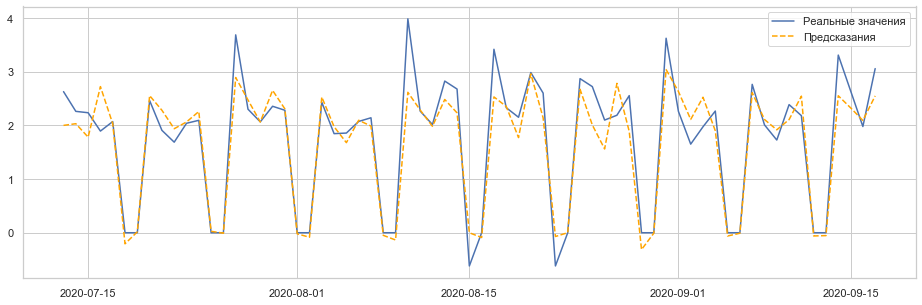

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(10,5)
%config InlineBackend.figure_format = 'png'

fig = plt.figure(figsize=(16, 5))
plt.plot(test_ts,label='Реальные значения')
plt.plot(pd.Series(preds[:-1], index=test_ts.index), c='orange', linestyle='--',label='Предсказания')
plt.legend()
plt.show()